In [1]:
import numpy as np
from pathlib import Path
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical

# Set paths
# -----------------------------
dataset_dir = Path("D:/VidSense/data/dataset")
model_dir = Path("D:/VidSense/models")
model_dir.mkdir(parents=True, exist_ok=True)

In [2]:
# Load train/test datasets
# -----------------------------
X_train = np.load(dataset_dir / "X_train.npy")
X_test  = np.load(dataset_dir / "X_test.npy")
y_train = np.load(dataset_dir / "y_train.npy")
y_test  = np.load(dataset_dir / "y_test.npy")

print("✔ Data loaded:")
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)

✔ Data loaded:
X_train: (9, 12, 512)
X_test : (3, 12, 512)
y_train: (9,)
y_test : (3,)


In [3]:
# -Encode labels for Keras
# -----------------------------
num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat  = to_categorical(y_test, num_classes=num_classes)

print("Number of classes:", num_classes)

Number of classes: 4


In [4]:
#Build CNN-LSTM model
# -----------------------------
# Input shape: (max_frames, feature_dim)
input_shape = X_train.shape[1:]  # (max_frames, 512)

model = Sequential()

# LSTM layer with dropout
model.add(LSTM(128, input_shape=input_shape, return_sequences=False))
model.add(Dropout(0.5))

# Dense layers for classification
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

# Compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print(model.summary())

C:\Users\Rajit\anaconda3\envs\vidsense_env\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │         328,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 336,708 (1.28 MB)

 Trainable params: 336,708 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

None


In [5]:

# Callbacks
# -----------------------------
checkpoint_path = model_dir / "cnn_lstm_best.h5"

checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

In [7]:
#Train model
# -----------------------------
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=50,
    batch_size=4,
    callbacks=[checkpoint, early_stop],
    verbose=1)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.0000e+00 - loss: 1.4003
Epoch 1: val_accuracy improved from None to 0.33333, saving model to D:\VidSense\models\cnn_lstm_best.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 671ms/step - accuracy: 0.0000e+00 - loss: 1.4310 - val_accuracy: 0.3333 - val_loss: 1.6616
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6389 - loss: 1.0413 
Epoch 2: val_accuracy did not improve from 0.33333
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.6667 - loss: 0.9991 - val_accuracy: 0.3333 - val_loss: 1.6565
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7593 - loss: 0.7768 
Epoch 3: val_accuracy did not improve from 0.33333
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.7778 - loss: 0.8625 - val_accuracy: 0.3333 - val_loss: 1.4658
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 0.3727 
Epoch 4: val_accuracy did not improve from 0.33333
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 0.4446 - val_accuracy: 0.3333 - val_loss: 1.3989
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6759 - loss: 0.7699 
Epoch 5: val_accuracy did not improve from 0.33

In [8]:
# Saving final model
# -----------------------------
final_model_path = model_dir / "cnn_lstm_final.h5"
model.save(final_model_path)
print("✔ Model saved to:", final_model_path)

✔ Model saved to: D:\VidSense\models\cnn_lstm_final.h5


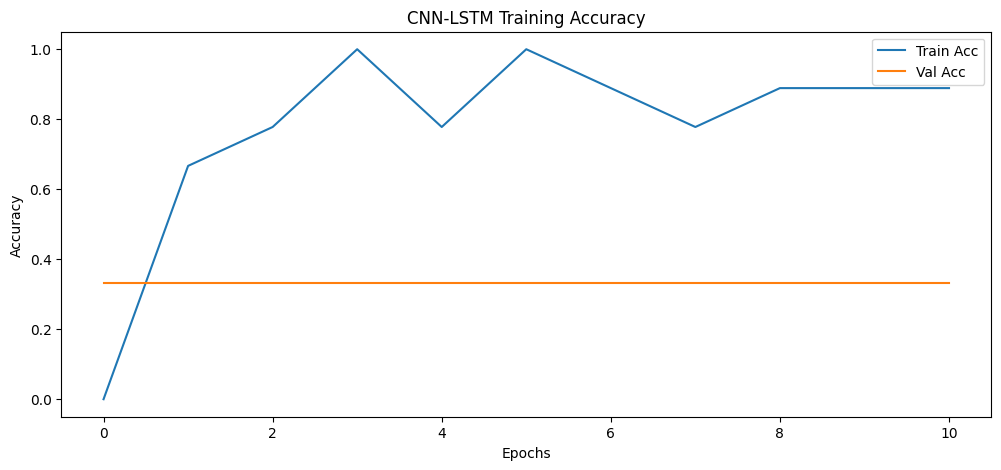

In [10]:
# Plot training history 
# -----------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CNN-LSTM Training Accuracy')
plt.legend()
plt.show()